Assume there is only one curved edge

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_surrounding(img, pt):
    '''
    Given a point, return a list of points that are surrounding of current points inside the image
    Sequence starts from top left.
    Array format:
    0 | 1 | 2
    3 | X | 4
    5 | 6 | 7
    In above, (0,1,2) is actually bottom, (5,6,7) is top
    '''
    temp = [[pt[0]-1,pt[1]-1],
            [pt[0]-1,pt[1]],
            [pt[0]-1,pt[1]+1],
            [pt[0],pt[1]-1],
            [pt[0],pt[1]+1],
            [pt[0]+1,pt[1]-1],
            [pt[0]+1,pt[1]],
            [pt[0]+1,pt[1]+1]]
    surrounding = [0, 1, 2, 3, 4, 5, 6, 7]
    dict_surrounding = dict(zip(surrounding, temp))
    h, w = img.shape
    for i, p in enumerate(temp):
        if(p[0] < 0 or p[1] < 0 or p[0] >= h or p[1] >= w):
            del dict_surrounding[i]
    return dict_surrounding

def reorder_connection(neumann_conn):
    '''
    Given a list of connected nodes, write a function to let it to be head-tail connected. 
    The order of each connection can be changed. For example if the input is 
    [[1,2],[2,4],[6,5],[4,3],[3,5]], the output should be 
    [[1,2],[2,4],[4,3],[3,5],[5,6]]. The first element of input should keep unchanged. 

    Input: neumann_conn, a list with each element is a two-element sublist
    Output: corrected order neumann_conn 
    '''

    graph = {}
    for a, b in neumann_conn:
        graph.setdefault(a, []).append(b)
        graph.setdefault(b, []).append(a)

    visited = set()
    result = []

    def dfs(node):
        for neighbor in graph[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                result.append([node, neighbor])
                dfs(neighbor)

    # Start from the first node in the input
    start_node = neumann_conn[0][0]
    visited.add(start_node)
    dfs(start_node)

    return np.array(result)

def define_curved_nodes(img):
    '''
    Define the curved boundary, also need to define connection. Please note that 
    this complex function needs to be validated if used in other cases. 

    The node id is arranged by row-first approach
    '''
    h_img, w_img = img.shape
    curved = np.zeros((h_img+1, w_img+1))
    curved_conn = []
    for i in range(h_img):
        for j in range(w_img):
            if(img[i,j]==1): # if there is material in current pixel i, j
                surrounding = find_surrounding(img, [i,j]) # surrounding pixels

                # if surrounding doesn't contain 1, it is bottom edge
                # if surrounding doesn't contain 6, it is top edge
                # if surrounding doesn't contain 3, it is left edge
                # if surrounding doesn't contain 4, it is right edge
                
                for key in surrounding: 
                    pt = surrounding[key]
                    if(img[pt[0],pt[1]]==0):
                        if(key == 0):
                            curved[i,j] = 1
                        if(key == 1):
                            curved[i,j] = 1
                            curved[i,j+1] = 1
                            curved_conn.append([
                                i*(w_img+1)+j,i*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 2):
                            curved[i,j+1] = 1
                        if(key == 3):
                            curved[i,j] = 1
                            curved[i+1,j] = 1
                            curved_conn.append([
                                i*(w_img+1)+j,(i+1)*(w_img+1)+j
                            ]) # generate a connection
                        if(key == 4):
                            curved[i,j+1] = 1
                            curved[i+1,j+1] = 1
                            curved_conn.append([
                                i*(w_img+1)+j+1,(i+1)*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 5):
                            curved[i+1,j] = 1
                        if(key == 6):
                            curved[i+1,j] = 1
                            curved[i+1,j+1] = 1
                            curved_conn.append([
                                (i+1)*(w_img+1)+j,(i+1)*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 7):
                            curved[i+1,j+1] = 1

    if(curved_conn is not []):
        curved_conn = reorder_connection(curved_conn)
    return [curved, curved_conn]

In [3]:
def circles_pattern(n=2**5, n_circ=[1,5], radius_frac=[1/20., 1/10.]):
    # randomly generate num_circ centroids, associate with a radius (distribute from size/8 to size/2)
    ## do the following if need no overlapping
    ## loop through every pair of the circles:
    ##   store the circle information if overlaping 
    ## remove all the stored circles
    # generate a zero plate with size of (n, n)
    # loop through points on the plate
    #   loop through the circles
    #   check if point fall into the circle, if yes -> change to 1
    size=2.
    h=size/n
    num_circ = np.random.randint(n_circ[0], n_circ[1])
    x, y = 2*np.random.random((num_circ,)), 2*np.random.random((num_circ,))
    radius = (size*radius_frac[1]-size*radius_frac[0])*np.random.random((num_circ,))+size*radius_frac[1]
    circs = np.stack((x, y, radius), axis=1)
    plate = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(n):
            x_i = h*(i+1)-0.5*h
            y_i = h*(j+1)-0.5*h
            for c in range(num_circ):
                d_sq = np.power(circs[c][0]-x_i, 2) + np.power(circs[c][1]-y_i, 2)
                if(d_sq < circs[c][2]*circs[c][2]):
                    plate[i][j] = 1.
    return plate

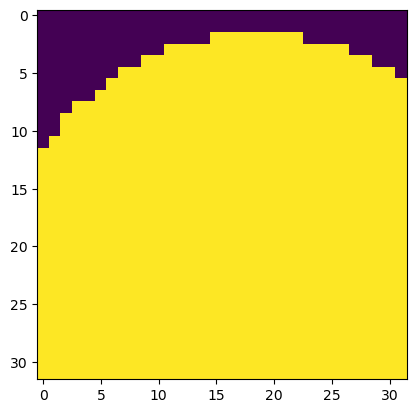

In [4]:
my_plate = circles_pattern(n_circ=[1,2], radius_frac=[1/4., 1/2.])
plt.imshow(my_plate)

In [5]:
curved, curved_conn = define_curved_nodes(my_plate)

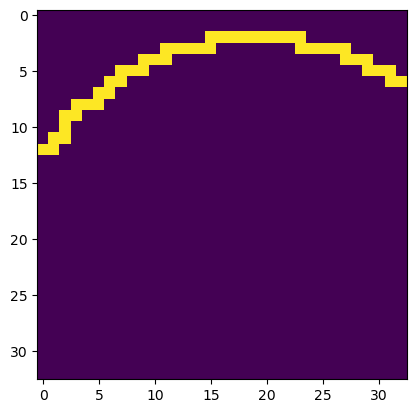

In [6]:
plt.imshow(curved)

In [7]:
a= {1: 400,
    2: 4550,
    4: 22}
4 not in a

False

In [8]:
def add_edge_connection(img, key, idx, conn, i, j):
    '''
    Node pattern:
    0 | 1 | 2
    3 | X | 4
    5 | 6 | 7
    '''
    _, w_img = img.shape

    if(key == 1 or key == 6):
        if(j == 0):
            idx[i,j] = 1
            idx[i+1,j] = 1
            conn.append([i*(w_img+1)+j,(i+1)*(w_img+1)+j])
        else:
            idx[i,j+1] = 1
            idx[i+1,j+1] = 1
            conn.append([i*(w_img+1)+j+1,(i+1)*(w_img+1)+j+1])
    if(key == 3 or key == 4):
        if(i == 0):
            idx[i,j] = 1
            idx[i,j+1] = 1
            conn.append([i*(w_img+1)+j,i*(w_img+1)+j+1])
        else: 
            idx[i+1,j] = 1
            idx[i+1,j+1] = 1
            conn.append([(i+1)*(w_img+1)+j,(i+1)*(w_img+1)+j+1])


In [9]:
def define_edge_nodes(img):
    '''
    Define edges other than the curved nodes
    Node pattern:
    0 | 1 | 2
    3 | X | 4
    5 | 6 | 7
    '''
    
    # define the straight boundary edges
    h_img, w_img = img.shape

    top_idx = np.zeros((h_img+1, w_img+1))
    bottom_idx = np.zeros((h_img+1, w_img+1))
    left_idx = np.zeros((h_img+1, w_img+1))
    right_idx = np.zeros((h_img+1, w_img+1))

    conns = 4*[[]] # top, bottom, left, right

    for i in range(h_img):
        for j in range(w_img):
            if(img[i,j]==1): # if there is material in current pixel i, j
                surr1 = find_surrounding(img, [i,j]) # surrounding pixels
                for key in surr1: 
                    pt = surr1[key]
                    if(img[pt[0],pt[1]]==1):
                        surr2 = find_surrounding(img, [pt[0],pt[1]])
                        if((6 not in surr1) and (6 not in surr2)):
                            # if surrounding doesn't contain 6, it is top edge
                            add_edge_connection(img, key, top_idx, conns[0], i, j)
                        if((1 not in surr1) and (1 not in surr2)):
                            # if surrounding doesn't contain 1, it is bottom edge
                            add_edge_connection(img, key, bottom_idx, conns[1], i, j)
                        if((3 not in surr1) and (3 not in surr2)):
                            # if surrounding doesn't contain 3, it is left edge
                            add_edge_connection(img, key, left_idx, conns[2], i, j)
                        if((4 not in surr1) and (4 not in surr2)):
                            # if surrounding doesn't contain 4, it is right edge
                            add_edge_connection(img, key, right_idx, conns[3], i, j)
    for i in range(len(conns)):
        if(conns[i] is not []):
            conns[i] = reorder_connection(conns[i])
            
    return [[top_idx, conns[0]], [bottom_idx, conns[1]], 
            [left_idx, conns[2]], [right_idx, conns[3]]]


In [26]:
def define_boundary_nodes(img):
    boundary = define_edge_nodes(img)
    curved_edge = define_curved_nodes(img) # assume there is only one curved edge
    boundary.append(curved_edge)
    return boundary

In [27]:
morenodes = define_boundary_nodes(my_plate)

In [34]:
print(morenodes[0][0].shape)
print(morenodes[1][0].shape)
print(morenodes[2][0].shape)
print(morenodes[3][0].shape)
print(morenodes[4][0].shape)

(33, 33)
(33, 33)
(33, 33)
(33, 33)
(33, 33)


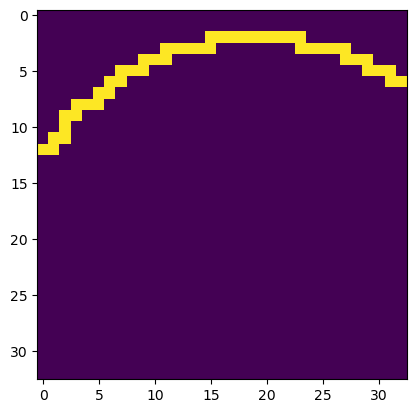

In [33]:
plt.imshow(morenodes[4][0])